# Predição de Ocupação de Leitos com SVR

 ### <b>  *CILAB - Computational Intelligence Laboratory*<b>

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
    
# **IMPORTANDO E LIMPANDO OS DADOS**
---
## Dados de Ocupação de Leitos de UTI

In [1]:
# Importando bibliotecas para manipulação visualização inicial
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('dados/ocup_leitos_covid19_atual.csv', sep=';', parse_dates=['data_coleta'])

df['taxa_ocup'] = df['taxa_ocup'].apply(lambda x: str(x).replace(',', '.'))
df['taxa_ocup'] = df['taxa_ocup'].astype('float64')
# Rearranjando colunas
df['alerta'] = df['uf'].values
df = df.rename(index=str, columns={'uf': 'Dias', 'alerta': 'uf', 'data_coleta': 'Data', 'taxa_ocup':'TaxaOcup'})
# Calculando coluna "dias" a partir das datas
df['Dias'] = df['Data'].apply(lambda x: abs((x - df['Data'].iloc[0]).days))

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Média da Ocupação de Leitos no Brasil

In [3]:
# Calculando médias das taxas de ocupação de leitos
med_brasil = list()
brasil = df.loc[(df.uf == 'Rondônia')]
for i in brasil.index:
    cond = df['Data'] == brasil['Data'][i]
    med_brasil.append(df.loc[cond, 'TaxaOcup'].mean())

In [5]:
# Atribuindo média de ocupação dos Estados da região
brasil.loc[:,'TaxaOcup'] = med_brasil.copy()

In [6]:
# Exclundo a coluna 'uf'
brasil = brasil.drop(['uf'], axis=1)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Dados de Vacinação no Brasil


In [7]:
vac = pd.read_csv('dados/vacinacao_2dose_atual.csv', parse_dates=['DataBrasil'])

index = np.array(range(len(vac)))
vac['index'] = index
vac = vac.set_index(['index'])

vac['PercentualBrasil'] = vac['PercentualBrasil'].apply(lambda x: str(x).replace(',', '.'))
vac['PercentualBrasil'] = vac['PercentualBrasil'].astype('float64')

vac['Dias'] = vac['DataBrasil'].apply(lambda x: abs((x - vac['DataBrasil'].iloc[0]).days))

vac = vac.rename(index=str, columns={'DataBrasil': 'Data', 'PercentualBrasil': 'Percentual'})

vac = vac[['Data', 'Dias', 'Percentual']]
#vac


### Criando novo dataframe de vacinas com todas as datas

In [8]:
Datas = brasil['Data']
Percentual = np.zeros(shape=len(brasil))
index = np.array(range(len(brasil)))

vacina = pd.DataFrame({'Data': Datas, 'Percentual': Percentual, 'index': index})
vacina = vacina.set_index(['index'])
vacina['Dias'] = vacina['Data'].apply(lambda x: abs((x - df['Data'].iloc[0]).days))
vacina = vacina[['Data', 'Dias', 'Percentual']]  

# Atribuindo valores de percentual a todas as datas
per = list()
cont = 0
for i in vacina.index:
    for j in vac.index:
        if  vacina.Data[i] == vac.Data[j]:
            vacina.loc[i, 'Percentual'] = vac.Percentual[j]

In [9]:
brasil['Vacina'] = vacina['Percentual'].values

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

---
# **>>> GRID SEARCH** 
---
# OCUPAÇÃO DE LEITOS

In [9]:
# Setando parâmetros para o modelo
#regressor = SVR(kernel = 'poly', C=1, gamma='auto', degree=8, epsilon=.101, coef0=1)
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Selecionado variáveis
X = brasil[['Dias', 'Vacina']]      #.values.reshape(-1, 1)
y = brasil['TaxaOcup'].values.reshape(-1, 1)   
z = brasil.iloc[:, 0].values.reshape(-1, 1)

In [10]:
'''from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Selecionado variáveis
X = brasil['Dias'].values.reshape(-1, 1)     #.values.reshape(-1, 1)
y = brasil['TaxaOcup'].values.reshape(-1, 1)  '''

"from sklearn.model_selection import RepeatedKFold\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.svm import SVR\n\n# Selecionado variáveis\nX = brasil['Dias'].values.reshape(-1, 1)     #.values.reshape(-1, 1)\ny = brasil['TaxaOcup'].values.reshape(-1, 1)  "

In [11]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [12]:
# Definindo model
model = SVR()
# Definindo validação cruzada
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [13]:
# Definindo espaço de busca
space = dict()
space['kernel'] = ['poly']
space['degree'] = [9]
space['C'] = [1, 95, 100, 1_000]
space['gamma'] = ['scale', 'auto']
space['coef0'] = [0, 0.1, 0.5, 1]

In [14]:
# define search
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

In [ ]:
# execute search
result = search.fit(X, y)

In [ ]:
# summarize result
print(f'Best Score: {result.best_score_}\n'
      f'Best Hyperparameters: {result.best_params_}')

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

# VACINAS

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Selecionado variáveis
X = vacina['Dias'].values.reshape(-1, 1)     #.values.reshape(-1, 1)
y = vacina['Percentual'].values.reshape(-1, 1)   

In [ ]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [ ]:
# Definindo model
model = SVR()
# Definindo validação cruzada
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
# Definindo espaço de busca
space = dict()
space['kernel'] = ['poly']
space['degree'] = [5]
space['C'] = [1, 100]#, 1_000, 10_000]
space['gamma'] = ['scale', 'auto']
space['coef0'] = [0, 0.5, 1]

In [ ]:
# define search
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

In [ ]:
# execute search
result = search.fit(X, y)

In [ ]:
# summarize result
print(f'Best Score: {result.best_score_}\n'
      f'Best Hyperparameters: {result.best_params_}')

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

---
# **>>> PREDIÇÃO** 
---
# VACINA

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Setando parâmetros para o modelo
regressor = SVR(kernel = 'rbf', C=10_000, gamma='scale', epsilon=1, coef0=0)

# Selecionado variáveis
X = vacina.iloc[:, 1].values.reshape(-1, 1)
y = vacina.iloc[:, 2].values.reshape(-1, 1)
z = vacina.iloc[:, 0].values.reshape(-1, 1)

In [11]:
# Último dia da lista
last_day = X[len(X)-1][0]
last_date = z[len(z)-1][0]
#print(f'Último dia: \033[1;34m{last_day}\033[m, data \033[1;34m{last_date}\033[m')
    
# Determiando dias para predizer valores futuros
x1 = np.array([[last_day], [last_day+7], [last_day+14], [last_day+21], [last_day+28]])
    
# Inserindo os dias para predizer dados futuros no array
X = np.concatenate((X, x1), axis=0)
    
'''# Normalizando os dados
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)'''
    
# Atribuindo valores a serem previstos
X_pred = X[len(vacina):]
    
# Desacoplando valores futuros de X (dias)
X = np.delete(X, len(X)-1, 0)
X = np.delete(X, len(X)-1, 0)
X = np.delete(X, len(X)-1, 0)
X = np.delete(X, len(X)-1, 0)
X = np.delete(X, len(X)-1, 0)

In [12]:
# Treinando o modelo
regressor.fit(X, y)
    
# Predizendo para valores de X futuros
y_pred = regressor.predict(X_pred)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred

/home/vini-silva/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([20.47970923, 21.72964557, 23.03503357, 24.37126574, 25.70536765])

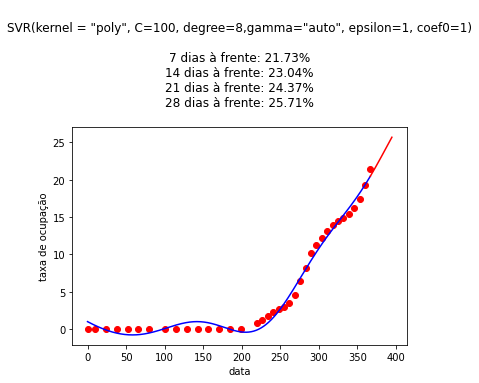

In [13]:
X_grid = np.arange(min(X), max(X), 0.01) #curva suave
X_grid = X_grid.reshape((len(X_grid), 1))

X_pred = np.arange(min(X_pred), max(X_pred), 0.01) #curva suave
X_pred = X_pred.reshape((len(X_pred), 1))
    
# Visualizando os dados 
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.plot(X_pred, regressor.predict(X_pred), color = 'red')
plt.title('\nSVR(kernel = "poly", C=100, degree=8,gamma="auto", epsilon=1, coef0=1)\n\n'
         f'7 dias à frente: {y_pred[1]:.2f}%\n'
         f'14 dias à frente: {y_pred[2]:.2f}%\n'
         f'21 dias à frente: {y_pred[3]:.2f}%\n'  #f'{"VACINA"}\n\n'
         f'28 dias à frente: {y_pred[4]:.2f}%\n')
plt.xlabel('data')
plt.ylabel('taxa de ocupação')
plt.show()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

# OCUPAÇÃO DE LEITOS

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.svm import SVR
#from sklearn.preprocessing import StandardScaler

regressor = SVR(kernel = 'rbf', C=10_000, gamma='scale', epsilon=1, coef0=1)

# Selecionado variáveis
X = brasil[['Dias', 'Vacina']]      #.values.reshape(-1, 1)
y = brasil['TaxaOcup'].values #.reshape(-1, 1)   
z = brasil.iloc[:, 0].values.reshape(-1, 1)

In [20]:
# Fitting model
regressor.fit(X, y)

SVR(C=10000, coef0=1, epsilon=1)

In [21]:
# ----------- For creating a prediciton plane to be used in the visualization -----------
# Set Increments between points in a meshgrid
mesh_size = 1

# Identify min and max values for input variables
x_min, x_max = X['Dias'].min(), X['Dias'].max()
y_min, y_max = X['Vacina'].min(), X['Vacina'].max()

# Return evenly spaced values based on a range between min and max
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)

# Create a meshgrid
xx, yy = np.meshgrid(xrange, yrange)

In [22]:
# ----------- Create a prediciton plane  -----------
# Use models to create a prediciton plane --- SVR
pred_svr = regressor.predict(np.c_[xx.ravel(), yy.ravel()])
pred_svr = pred_svr.reshape(xx.shape)

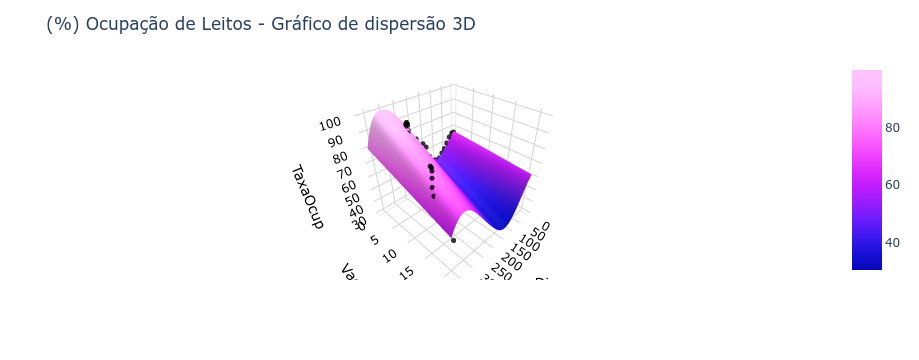

In [23]:
# Create a 3D scatter plot with predictions
fig = px.scatter_3d(brasil, x=brasil['Dias'], y=brasil['Vacina'], z=brasil['TaxaOcup'], 
                 opacity=0.8, color_discrete_sequence=['black'])

# Set figure title and colors
fig.update_layout(title_text="(%) Ocupação de Leitos - Gráfico de dispersão 3D",
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='lightgrey'),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='lightgrey'),
                               zaxis=dict(backgroundcolor='white',
                                          color='black', 
                                          gridcolor='lightgrey')))
# Update marker size
fig.update_traces(marker=dict(size=3))

# Add prediction plane
fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred_svr, name='SVR',
                          colorscale=px.colors.sequential.Plotly3))

fig.show()

In [ ]:
# Último dia da lista
last_day = X1[len(X1)-1]#[0]
last_date = z[len(z)-1]#[0]
#print(f'Último dia: \033[1;34m{last_day}\033[m, data \033[1;34m{last_date}\033[m')
    
# Determiando dias para predizer valores futuros
x1 = np.array([last_day, last_day+7, last_day+14, last_day+21, last_day+28])
    
# Inserindo os dias para predizer dados futuros no array
X1 = np.concatenate((X1, x1), axis=0)

In [ ]:
# Determiando dias para predizer valores futuros
x2 = np.array([y_pred[0], y_pred[1], y_pred[2], y_pred[3], y_pred[4]])
    
# Inserindo os dias para predizer dados futuros no array
X2 = np.concatenate((X2, x2), axis=0)

In [ ]:
index = np.array(range(len(X1)))

In [ ]:
W = pd.DataFrame({'Data': X1, 'Vacina': X2, 'index': index})

In [ ]:
W = W.set_index(['index'])

In [ ]:
# Normalizando os dados
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(W)
y = sc_y.fit_transform(y)

In [ ]:
# Atribuindo valores a serem previstos
X_pred = X[len(brasil):]
X_tran = X[:len(brasil)]

In [ ]:
# Desacoplando valores futuros de X (dias)
X = np.delete(X, len(X)-1, 0)
X = np.delete(X, len(X)-1, 0)
X = np.delete(X, len(X)-1, 0)
X = np.delete(X, len(X)-1, 0)
X = np.delete(X, len(X)-1, 0)

In [ ]:
# Treinando o modelo
regressor = SVR(kernel = 'rbf', C=10000, gamma='auto', epsilon=.1, coef0=0)
regressor.fit(X, y)

In [ ]:
#X_tran

In [ ]:
AX, AY = list(), list()
for i in range(len(X)):
    AX.append(X[i][0]) 
    AY.append(X[i][1])

In [ ]:
#AX

## VALORES ATUAIS

In [ ]:
# Predizendo para valores de X futuros
Y_tran = regressor.predict(X_tran)
Y_tran = sc_y.inverse_transform(Y_tran)

In [ ]:
Y_tran

In [ ]:
YY_tran = regressor.predict(X)

In [ ]:
AZ = list(YY_tran)

## VALORES FUTUROS

In [ ]:
# Predizendo para valores de X futuros
Y_pred = regressor.predict(X_pred)
Y_pred = sc_y.inverse_transform(Y_pred)

In [ ]:
Y_pred